<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [ ]:
%%bash
pip install --no-cache-dir -qU \
  tensorflow tensorflow-probability[tf]

({'image': TensorSpec(shape=(None, 105, 105, 3), dtype=tf.uint8, name=None),
  'alphabet_char_id': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)},
 {'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'alphabet': TensorSpec(shape=(None, 50), dtype=tf.float32, name=None)})

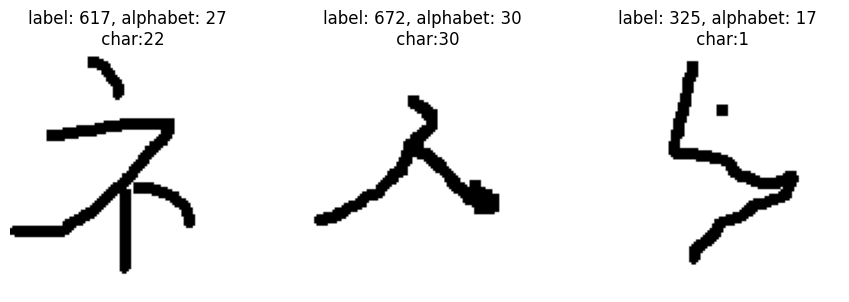

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

ds_train = tfds.load(name="omniglot", split="train+test")
ds_test = tfds.load(name="omniglot", split="small1+small2")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
for ax, x in zip(axes, ds_train.take(3)):
    ax.imshow(X=x["image"], cmap="gray")
    ax.set_title(label=x["alphabet_char_id"])
    ax.set_title(label="label: %d, alphabet: %d \n char:%d"%(
        x["label"], x["alphabet"], x["alphabet_char_id"]))
    ax.axis("off")
fig.tight_layout()
fig.show()

def get_ds(ds, shuffle=False):
    ds = ds.cache().map(map_func=lambda x: ({
        "image": x["image"],
        "alphabet_char_id": tf.expand_dims(x["alphabet_char_id"], axis=-1)
    }, {
        "label": x["label"],
        "alphabet": tf.keras.utils.to_categorical(
            x=x["alphabet"], num_classes=50)
    }))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(ds))
    ds = ds.batch(batch_size=256)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(ds=ds_train, shuffle=True)
ds_test = get_ds(ds=ds_test)
ds_test.element_spec

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

inputs = {
    "image": tf.keras.Input(name="image",
        shape=(105, 105, 3), dtype=tf.uint8),
    "alphabet_char_id": tf.keras.Input(name="alphabet_char_id",
        shape=(1,), dtype=tf.int64)
}

class ImagePreprocessLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocessor = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255.0),
            tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(factor=0.2),
            tf.keras.layers.Resizing(height=64, width=64),
        ])

    @tf.function
    def call(self, inputs):
        return self.preprocessor(inputs=inputs)

x_image = ImagePreprocessLayer()(inputs=inputs["image"])
h_image = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same",
    activation=tf.keras.activations.relu)(inputs=x_image)
h_image = tf.keras.layers.MaxPool2D(pool_size=2)(inputs=h_image)
h_image = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same",
    activation=tf.keras.activations.relu)(inputs=h_image)
h_image = tf.keras.layers.MaxPool2D(pool_size=2)(inputs=h_image)
h_image = tf.keras.layers.Flatten()(inputs=h_image)

x_char = tf.keras.layers.Embedding(input_dim=55, output_dim=8)(
    inputs=inputs["alphabet_char_id"])
h_char = tf.keras.layers.Flatten()(inputs=x_char)

h = tf.keras.layers.Concatenate(axis=-1)(inputs=[h_image, h_char])

outputs = {
    "label": tf.keras.layers.Dense(name="label", units=1623,
        activation=tf.keras.activations.softmax)(inputs=h),
    "alphabet": tf.keras.layers.Dense(name="alphabet", units=50,
        activation=tf.keras.activations.softmax)(inputs=h)
}

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss ={
        "label": tf.keras.losses.SparseCategoricalCrossentropy(),
        "alphabet": tf.keras.losses.CategoricalCrossentropy()
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = {
        "label": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
        "alphabet": [tf.keras.metrics.CategoricalAccuracy(name="acc")]
    }
)
model.fit(x=ds_train, validation_data=ds_test, epochs=1)

127/127 ━━━━━━━━━━━━━━━━━━━━ 471s 4s/step - alphabet_acc: 0.0562 - alphabet_loss: 3.7946 - label_acc: 0.0021 - label_loss: 7.4341 - loss: 11.2287 - val_alphabet_acc: 0.0479 - val_alphabet_loss: 3.7337 - val_label_acc: 0.0185 - val_label_loss: 6.8618 - val_loss: 10.5960


({'image': TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None)},
 {'class': TensorSpec(shape=(None,), dtype=tf.uint8, name=None),
  'binary': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'regress': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})

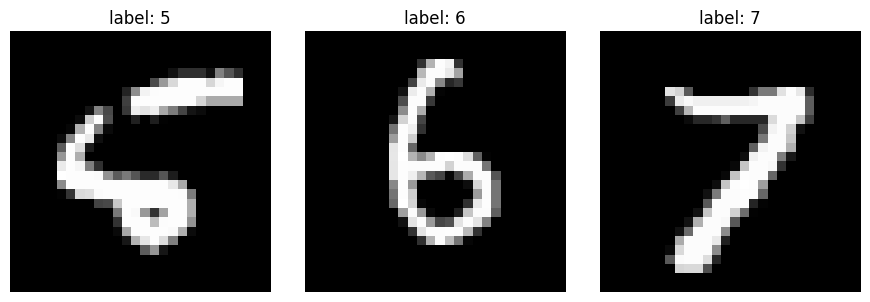

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
fig.show()

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    ds = ds.map(map_func=lambda x, y: ({
        "image": x
    }, {
        "class": y,
        "binary": tf.cast(x=(y%2==0), dtype=tf.int32),
        "regress": 7.9+3.4*tf.math.square(x=tf.cast(x=y, dtype=tf.float32))
    }))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

inputs = {}
for name, spec in ds_train.element_spec[0].items():
    inputs[name] = tf.keras.Input(name=name,
        shape=(28, 28, 1), dtype=spec.dtype)

x = tf.keras.layers.Rescaling(scale=1./255)(inputs["image"])

h = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same",
    activation=tf.keras.activations.relu)(inputs=x)
h = tf.keras.layers.MaxPool2D(pool_size=2)(inputs=h)
h = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same",
    activation=tf.keras.activations.relu)(inputs=h)
h = tf.keras.layers.MaxPool2D(pool_size=2)(inputs=h)
h = tf.keras.layers.Flatten()(inputs=h)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)

outputs = {
    "class": tf.keras.layers.Dense(name="class", units=10,
        activation=tf.keras.activations.softmax)(inputs=h),
    "binary": tf.keras.layers.Dense(name="binary", units=1,
        activation=tf.keras.activations.sigmoid)(inputs=h),
    "regress": tf.keras.layers.Dense(name="regress", units=1,
        activation=tf.keras.activations.linear)(inputs=h)
}

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
loss = {
    "class": tf.keras.losses.SparseCategoricalCrossentropy(),
    "binary": tf.keras.losses.BinaryCrossentropy(),
    "regress": tf.keras.losses.MeanSquaredError()
},
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
metrics = {
    "class": [
        tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
    ],
    "binary": [
        tf.keras.metrics.BinaryAccuracy(name="acc")
    ],
    "regress": [
        tf.keras.metrics.MeanAbsoluteError(name="mae")
    ]
})

In [ ]:
model.fit(x=ds_train, validation_data=ds_test, epochs=1)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - binary_acc: 0.8003 - binary_loss: 0.4972 - class_acc: 0.7276 - class_loss: 1.0825 - loss: 6956.7891 - regress_loss: 6955.2114 - regress_mae: 66.0202 - val_binary_acc: 0.9130 - val_binary_loss: 0.2231 - val_class_acc: 0.9120 - val_class_loss: 0.4620 - val_loss: 2756.7681 - val_regress_loss: 2756.3079 - val_regress_mae: 39.5926


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


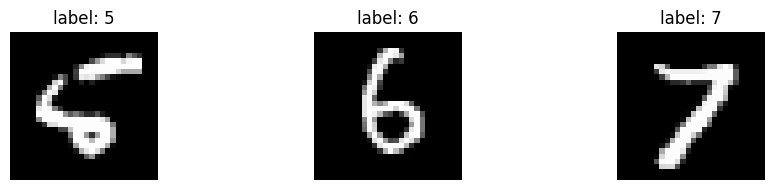

(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 52s


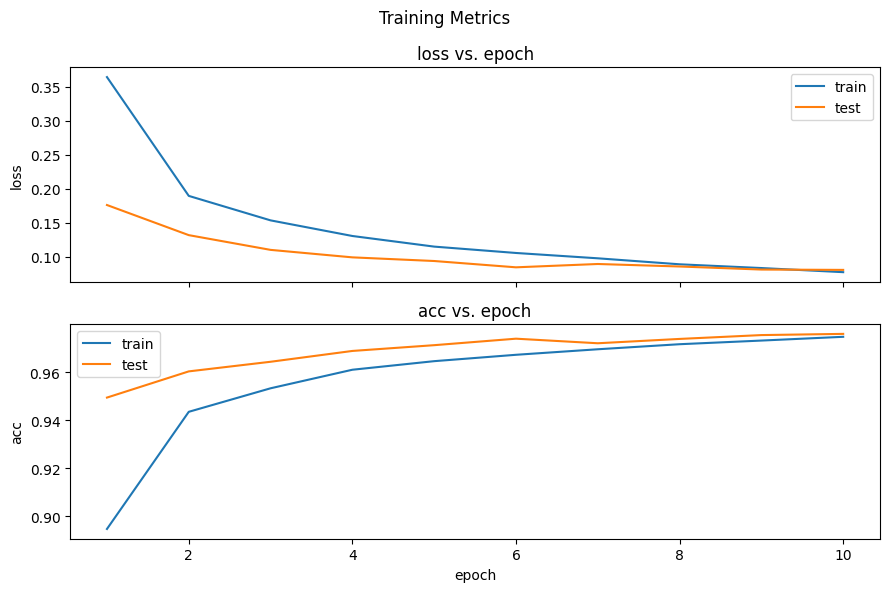

In [ ]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@keras.saving.register_keras_serializable()
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def call(self, inputs):
        return self.preprocess(inputs=inputs)

x = tf.keras.Input(name="Images", shape=(28, 28), dtype=tf.float32)
h = PreprocessingLayer(name="preprocessing")(inputs=x)
h = tf.keras.layers.Dense(units=64,
    activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=h)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
model = tf.keras.Model(inputs=x, outputs=y)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
]

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model, add_history=True,
    callbacks=[ckptModel, reduceLR])

@tf.function(reduce_retracing=True)
def train_step(data):
    x, y = data
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function(reduce_retracing=True)
def test_step(data):
    x, y = data
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"test_{m.name}": m.result() for m in metrics}

start_time = time.time()
history, logs = [], {}
callbacks.on_train_begin(logs=logs)
for epoch in range(10):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for data in ds_train:
        logs = train_step(data=data)
    for m in metrics:
        m.reset_state()

    for data in ds_test:
        logs_test = test_step(data=data)
    logs.update(logs_test)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append({k: v.numpy() for k, v in logs.items()})
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 6))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    ax.set_title(label=f"{m.name} vs. epoch")
    ax.set_ylabel(ylabel=m.name)
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

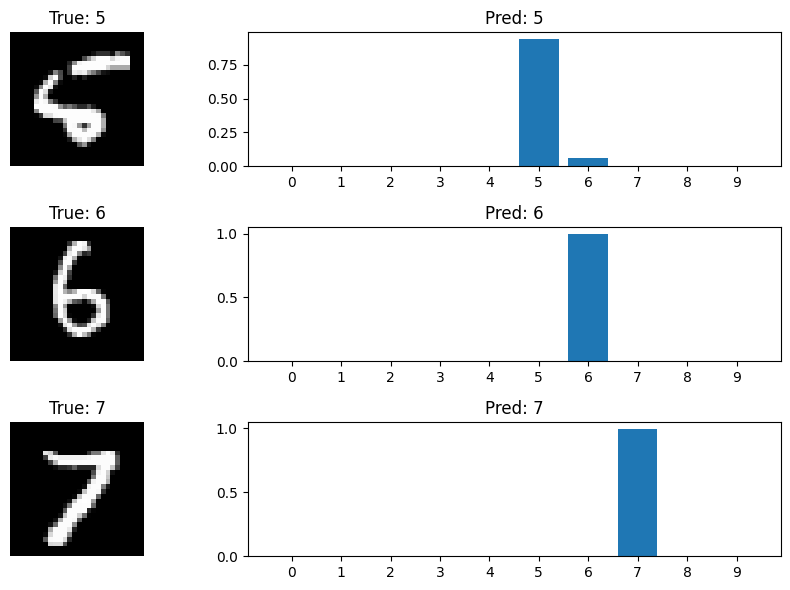

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
model.load_weights(ckptPath)
probs = model(inputs=x_plt)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()

## Models with multiple inputs and outputs

In [9]:
import tensorflow as tf
import pandas as pd

origin = "https://www.kaggle.com/api/v1/datasets/download/johnsmith88/heart-disease-dataset/heart.csv"
df = pd.read_csv(tf.keras.utils.get_file(origin=origin))

df["sex"] = df["sex"].map({0: "female", 1: "male"})
df["cp"] = df["cp"].map({0: "typical angina", 1: "atypical angina",
    2: "non-anginal pain", 3: "asymptomatic"})
df["fbs"] = df["fbs"].map({0: "false", 1: "true"})
df["restecg"] = df["restecg"].map({0: "normal", 1: "ST-T wave abnormality",
    2: "left ventricular hypertrophy"})
df["exang"] = df["exang"].map({0: "no", 1: "yes"})
df["slope"] = df["slope"].map({0: "upsloping", 1: "flat", 2: "downsloping"})
df["thal"] = df["thal"].map({0: "normal", 1: "normal",
    2: "fixed defect", 3: "reversable defect"})
df["target"] = df["target"].map({0: "normal", 1: "disease"})

df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   object 
 2   cp        1025 non-null   object 
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   object 
 6   restecg   1025 non-null   object 
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   object 
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   object 
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   object 
 13  target    1025 non-null   object 
dtypes: float64(1), int64(5), object(8)
memory usage: 112.2+ KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1020,59,male,atypical angina,140,221,false,ST-T wave abnormality,164,yes,0.0,downsloping,0,fixed defect,disease
1021,60,male,typical angina,125,258,false,normal,141,yes,2.8,flat,1,reversable defect,normal
1022,47,male,typical angina,110,275,false,normal,118,yes,1.0,flat,1,fixed defect,normal
1023,50,female,typical angina,110,254,false,normal,159,no,0.0,downsloping,0,fixed defect,disease
1024,54,male,typical angina,120,188,false,ST-T wave abnormality,113,no,1.4,flat,1,reversable defect,normal


In [11]:
import tensorflow as tf

ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df)).cache()
ds = ds.map(map_func=lambda x: (x, {
    "target": x.pop("target"),
    "thalach": x.pop("thalach")
}))
ds = ds.shuffle(buffer_size=len(df))
ds = ds.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
ds.element_spec

({'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'cp': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'fbs': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'restecg': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'exang': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'slope': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'thal': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 {'target': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn import model_selection

origin = 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv'
fname = 'heart.csv'
csv_file = tf.keras.utils.get_file(fname=fname, origin=origin)

df_data = pd.read_csv(csv_file)
df_train, df_test = model_selection.train_test_split(df_data,
    test_size=0.1, random_state=42)

def get_ds(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df)).cache()
    ds = ds.map(map_func=lambda x: (x, {"target": x.pop("target")}))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(df=df_train, shuffle=True)
ds_test = get_ds(df=df_test, shuffle=False)
ds_test.element_spec

({'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'sex': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'cp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'fbs': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'restecg': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'exang': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'slope': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'thal': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 {'target': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})

In [ ]:
import tensorflow as tf

inputs, preprocessed = {}, []
for name, spec in ds_train.element_spec[0].items():
    dtype = spec.dtype
    inputs[name] = tf.keras.Input(name=name, shape=(1,), dtype=dtype)

# Binary columns
binary_cols = ["sex", "fbs", "exang"]
for name in binary_cols:
    preprocessed.append(inputs[name])

# Categorical columns
categoric_cols = ["cp", "restecg", "slope", "ca", "thal"]
for name in categoric_cols:
    dtype = ds_train.element_spec[0][name].dtype
    if dtype=="string":
        lookup = tf.keras.layers.StringLookup(output_mode="one_hot")
    else:
        lookup = tf.keras.layers.IntegerLookup(output_mode="one_hot")
    feature_ds = ds_train.map(lambda x, _: x[name])
    lookup.adapt(data=feature_ds)
    preprocessed.append(lookup(inputs[name]))

# Numerical columns
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
for name in numeric_cols:
    normalizer = tf.keras.layers.Normalization(axis=None)
    feature_ds = ds_train.map(lambda x, _: x[name][:, tf.newaxis])
    normalizer.adapt(data=feature_ds)
    preprocessed.append(normalizer(inputs[name]))

preprocessed_result = tf.keras.layers.Concatenate(axis=-1)(preprocessed)
preprocessor = tf.keras.Model(inputs=inputs, outputs=preprocessed_result)

for x, y in ds_train.take(1):
    print(preprocessor(inputs=x))

Training duration: 11s


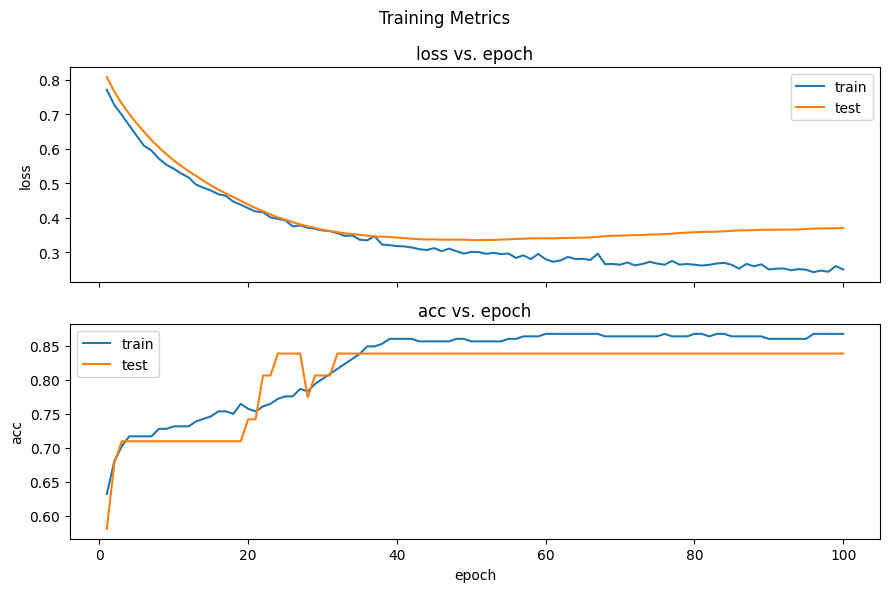

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

x = preprocessor(inputs)
h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu)(x)
# h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu)(h)
predicted_target = tf.keras.layers.Dense(units=1)(h)
model = tf.keras.Model(inputs=inputs, outputs=predicted_target)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.BinaryAccuracy(name="acc")
]

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=10, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model, add_history=True,
    callbacks=[ckptModel, reduceLR])

@tf.function(reduce_retracing=True)
def train_step(data):
    x, y = data
    y = y["target"]
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function(reduce_retracing=True)
def test_step(data):
    x, y = data
    y = y["target"]
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"test_{m.name}": m.result() for m in metrics}

start_time = time.time()
history, logs = [], {}
callbacks.on_train_begin(logs=logs)
for epoch in range(100):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for data in ds_train:
        logs = train_step(data=data)
    for m in metrics:
        m.reset_state()

    for data in ds_test:
        logs_test = test_step(data=data)
    logs.update(logs_test)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append({k: v.numpy() for k, v in logs.items()})
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 6))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    ax.set_title(label=f"{m.name} vs. epoch")
    ax.set_ylabel(ylabel=m.name)
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

In [ ]:
model.load_weights(ckptPath)
df_sample = df_test.copy()
X_test, y_test = df_sample, df_sample.pop("target")
prob = tf.math.sigmoid(model(inputs=dict(X_test)))
y_pred = tf.squeeze(tf.cast(prob > 0.5, tf.int64))
y_true = y_test.values
tf.keras.metrics.BinaryAccuracy()(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8064516186714172>